# SNN Implementation
## By Aryan Mehta (20BCE018)


In [97]:
!pip install snntorch --quiet

In [79]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

def dvs_animator(spike_data):
  fig, ax = plt.subplots()
  anim = splt.animator((spike_data[:,0] + spike_data[:,1]), fig, ax)
  return anim


In [80]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
import torch

# plotting
import matplotlib.pyplot as plt
from IPython.display import HTML

In [98]:
lif = snn.Leaky(beta=0.8) # LIF neuron with a decay rate of 0.8

In [82]:
# setup inputs
num_steps = 200 # number of time-steps to simulate

w = 0.8 # then run 0.15, 0.20, 0.21
# First run spike input
x = torch.cat((torch.zeros(10), torch.ones(1)*w, torch.zeros(189)))


# Small step current input
# w = 0.15, # then run 0.20, 0.21
# x = torch.cat((torch.zeros(10), torch.ones(190)*w), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)

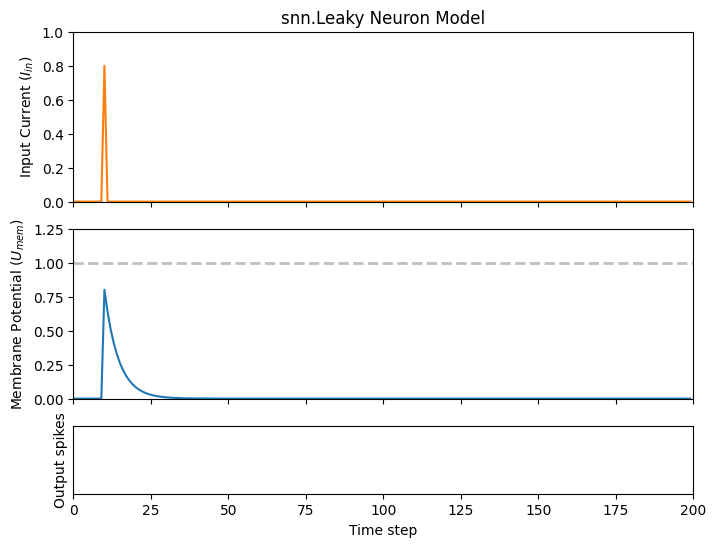

In [83]:
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  spk, mem = lif(x[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(x, mem_rec, spk_rec, thr_line=1, ylim_max1=1.0,
                 title="snn.Leaky Neuron Model")

In [84]:
# import
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools

In [85]:
# dataloader arguments
batch_size = 128
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
## if you're on M1 or M2 GPU:
# device = torch.device("mps")

In [99]:
import pandas as pd
df=pd.read_csv("/content/resampled_dataset.csv")

In [100]:

df.drop(['Node_ID','Timestamp','IP_Address'], axis=1,inplace=True)
df

,Packet_Rate,Packet_Drop_Rate,Packet_Duplication_Rate,Data_Throughput,Signal_Strength,SNR,Battery_Level,Energy_Consumption_Rate,Number_of_Neighbors,Route_Request_Frequency,Route_Reply_Frequency,Data_Transmission_Frequency,Data_Reception_Frequency,Error_Rate,CPU_Usage,Memory_Usage,Bandwidth,Is_Malicious
0,43.354826,1.793314,0.769017,102.475187,-51.956973,22.138247,100.590005,4.564164,4,8.782660,5.198217,18.030080,11.166828,0.102339,49.768780,28.702876,81.062645,0
1,50.424976,2.260854,0.937936,73.107409,-54.428835,27.228791,85.219354,3.171772,7,9.189567,8.178341,14.910599,15.063865,0.113781,51.223214,24.476745,79.475488,0
2,46.428791,1.471781,0.781682,135.236742,-52.132566,17.398257,63.941000,6.169996,8,9.225129,10.643191,12.670805,16.675159,0.111805,39.546487,30.593333,81.404470,0
3,51.067513,1.384181,1.438859,104.536678,-40.616531,15.721254,77.999125,3.739826,5,10.747214,10.774255,14.797984,19.334244,0.101249,41.455883,33.279822,80.681986,0
4,52.115473,2.075577,1.126520,114.661321,-48.377337,25.703275,55.602428,5.000826,4,7.461444,8.501757,13.459489,14.455538,0.059275,18.144486,29.858013,90.707117,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14263,55.276199,2.787557,0.934684,38.362757,-37.112532,13.687636,69.903849,11.043002,2,16.390677,18.765169,23.431158,25.901908,0.180820,52.213197,43.052908,46.084743,1
14264,55.276199,2.787557,0.934684,38.362757,-37.112532,13.687636,69.903849,11.043002,2,16.390677,18.765169,23.431158,25.901908,0.180820,52.213197,43.052908,46.084743,1
14265,113.825524,1.975563,0.886370,62.056350,-36.487645,10.722136,55.023471,11.594558,6,11.004521,15.827568,20.675146,16.089891,0.250556,58.404848,34.227697,60.075611,1
14266,89.374541,4.814556,1.117471,33.992990,-41.181198,19.880221,65.091574,10.954954,6,14.345728,12.271464,23.462420,18.875817,0.223306,53.961389,45.886451,88.966717,1


In [335]:
from sklearn.model_selection import train_test_split
y=df.iloc[:,17]

Xtrain, Xtest, ytrain, ytest = train_test_split(df.iloc[:,:17], y, test_size=0.2, random_state=42, stratify=y)

In [336]:
print("X_train shape:", Xtrain.shape)
print("X_test shape:", Xtest.shape)
print("y_train shape:", ytrain.shape)
print("y_test shape:", ytest.shape)

X_train shape: (11414, 17)
X_test shape: (2854, 17)
y_train shape: (11414,)
y_test shape: (2854,)


In [337]:
# Xtrain=df.iloc[:8000,:17]
# ytrain=df.iloc[:8000,17]
# Xtest=df.iloc[8000:,:17]
# ytest=df.iloc[8000:,17]

In [338]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and testing data
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

In [339]:
Xtrain_scaled

array([[0.35916952, 0.31326802, 0.42078913, ..., 0.53670599, 0.45717352,
        0.66331931],
       [0.24945998, 0.25628104, 0.3283059 , ..., 0.3968639 , 0.47796234,
        0.61651364],
       [0.27793507, 0.2361477 , 0.77003014, ..., 0.43939362, 0.3104201 ,
        0.54573437],
       ...,
       [0.48013703, 0.30452655, 0.61636011, ..., 0.43232314, 0.3158845 ,
        0.48806449],
       [0.91061601, 0.76545482, 0.5039804 , ..., 0.67254121, 0.52051156,
        0.49263579],
       [0.53706906, 0.78850659, 0.30419535, ..., 0.61090598, 0.60953805,
        0.31342068]])

In [340]:
ytest.values

array([0, 0, 0, ..., 0, 1, 0])

In [341]:
tensorXtrain = torch.tensor(Xtrain_scaled, dtype=torch.float32)
tensorXtest = torch.tensor(Xtest_scaled, dtype=torch.float32)


In [342]:
ytrain2=np.array(ytrain)
ytest2=np.array(ytest)


In [343]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, tensor_data, ytrain):
        self.tensor_data = tensor_data
        self.ytrain = ytrain

    def __len__(self):
        return len(self.tensor_data)

    def __getitem__(self, index):
        data = self.tensor_data[index]
        label = self.ytrain[index]

        return data, label

# Assuming tensor_data and ytrain are your tensor and output values
#tensor_data = torch.tensor([[0.3707, 0.4219, 0.4833, 0.2966, 0.3640, 0.3620], [...]])
ytrainnew = torch.tensor(ytrain2)  # Replace this with your actual output values

# Create an instance of your custom dataset
custom_train_dataset = CustomDataset(tensorXtrain, ytrainnew)

# Now, you can use custom_dataset in combination with DataLoader for training or testing


In [344]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, tensor_data, ytrain):
        self.tensor_data = tensor_data
        self.ytrain = ytrain

    def __len__(self):
        return len(self.tensor_data)

    def __getitem__(self, index):
        data = self.tensor_data[index]
        label = self.ytrain[index]

        return data, label

# Assuming tensor_data and ytrain are your tensor and output values
#tensor_data = torch.tensor([[0.3707, 0.4219, 0.4833, 0.2966, 0.3640, 0.3620], [...]])
ytestnew = torch.tensor(ytest2)  # Replace this with your actual output values

# Create an instance of your custom dataset
custom_test_dataset = CustomDataset(tensorXtest, ytestnew)

# Now, you can use custom_dataset in combination with DataLoader for training or testing


In [345]:
custom_test_dataset[0]

(tensor([0.4387, 0.3839, 0.5964, 0.4091, 0.4795, 0.3650, 0.5133, 0.1931, 0.2857,
         0.4634, 0.5079, 0.2810, 0.4617, 0.2682, 0.2875, 0.1923, 0.5549]),
 tensor(0))

In [346]:
# # Define a transform
# transform = transforms.Compose([
#             transforms.Resize((28, 28)),
#             transforms.Grayscale(),
#             transforms.ToTensor(),
#             transforms.Normalize((0,), (1,))])

# mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
# mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

In [414]:
# Create DataLoaders
batch_size=64
train_loader = DataLoader(custom_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(custom_test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [415]:
train_loader

## Construct a Fully Connected SNN

In [416]:
# Network Architecture
num_inputs = 17
num_hidden = 30
num_outputs = 2

# Temporal Dynamics
num_steps = 20
beta = 0.95

In [417]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

## Training the SNN

In [418]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)# betas=(0.9, 0.999)

num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    running_length = 0
    running_accuracy = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = net(data.flatten(1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val += loss(spk_rec.sum(0), targets)

        spike_count = spk_rec.sum(0)
        _, max_spike = spike_count.max(1)
        num_correct = (max_spike == targets).sum()

      # total accuracy
        running_length += len(targets)
        running_accuracy += num_correct

        accuracy = (running_accuracy / running_length)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print train/test loss/accuracy
        if counter % 10 == 0:
            print(f"Iteration: {counter} \t Train Loss: {loss_val.item()} \t Train acc:{accuracy}")
        counter += 1

        # if counter == 100:
        #     break

Iteration: 0 	 Train Loss: 0.6286965012550354 	 Train acc:0.796875
Iteration: 10 	 Train Loss: 0.578186571598053 	 Train acc:0.7613636255264282
Iteration: 20 	 Train Loss: 0.40941348671913147 	 Train acc:0.757440447807312
Iteration: 30 	 Train Loss: 0.37811675667762756 	 Train acc:0.7767137289047241
Iteration: 40 	 Train Loss: 0.2575092911720276 	 Train acc:0.8041158318519592
Iteration: 50 	 Train Loss: 0.2517554461956024 	 Train acc:0.8321078419685364
Iteration: 60 	 Train Loss: 0.1893683224916458 	 Train acc:0.8524590134620667
Iteration: 70 	 Train Loss: 0.1500024050474167 	 Train acc:0.8699383735656738
Iteration: 80 	 Train Loss: 0.07055790722370148 	 Train acc:0.8836805820465088
Iteration: 90 	 Train Loss: 0.09028278291225433 	 Train acc:0.895432710647583
Iteration: 100 	 Train Loss: 0.04960007965564728 	 Train acc:0.9050123691558838
Iteration: 110 	 Train Loss: 0.05338560789823532 	 Train acc:0.9132882952690125
Iteration: 120 	 Train Loss: 0.04217853397130966 	 Train acc:0.9203253

In [359]:
"""
num_of_time_steps=5
tr_loss=0.0970378890633583
tr_acc=0.8893457651138306

num_of_time_steps=10
tr_loss=0.021145569160580635
tr_acc=0.9135599136352539

num_of_time_steps=15
tr_loss=0.015559270977973938
tr_acc=0.9367690086364746

num_of_time_steps=20
tr_loss=0.015375244431197643
tr_acc=0.9435306787490845

num_of_time_steps=25
tr_loss=0.000845050613861531
tr_acc=0.9588815569877625
"""

'\nnum_of_time_steps=5\n\n'

In [ ]:
"""PLOT CODE
% Data
num_of_time_steps = [5, 10, 15, 20, 25];
tr_loss = [0.0970378890633583, 0.021145569160580635, 0.015559270977973938, 0.015375244431197643, 0.000845050613861531];
tr_acc = [0.8893457651138306, 0.9135599136352539, 0.9367690086364746, 0.9435306787490845, 0.9588815569877625];

% Create a figure
figure;

% Bar graph for accuracy
bar(num_of_time_steps , tr_acc, 0.4, 'FaceColor', [0.2 0.4 0.6], 'DisplayName', 'Accuracy');
hold on;

% Bar graph for loss
bar(num_of_time_steps , tr_loss, 0.4, 'FaceColor', [0.8 0.2 0.2], 'DisplayName', 'Loss');

% Labels and title
xlabel('Number of Time Steps');
ylabel('Training Accuracy / Loss');
title('Training Accuracy and Loss vs. Time Steps');
legend('show');
grid on;

% Display values on top of the bars for accuracy
text(num_of_time_steps - 0.25, tr_acc, num2str(tr_acc', '%.4f'), ...
    'HorizontalAlignment', 'center', 'VerticalAlignment', 'bottom');

% Display values on top of the bars for loss
text(num_of_time_steps + 0.25, tr_loss, num2str(tr_loss', '%.4f'), ...
    'HorizontalAlignment', 'center', 'VerticalAlignment', 'bottom');

"""

In [ ]:
spk_rec.sum(0)

In [325]:
targets

tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0])

In [402]:
def measure_accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
      data = data.to(device)
      targets = targets.to(device)

      # forward-pass
      spk_rec, _ = model(data.flatten(1))
      spike_count = spk_rec.sum(0)
      _, max_spike = spike_count.max(1)

      # correct classes for one batch
      num_correct = (max_spike == targets).sum()

      # total accuracy
      running_length += len(targets)
      running_accuracy += num_correct

    accuracy = (running_accuracy / running_length)

    return accuracy.item()


In [403]:
print(f"Test set accuracy: {measure_accuracy(net, test_loader)}")

Test set accuracy: 0.9946733117103577


In [ ]:
"""
Adam- 1
SGD-0.6690340638160706
RMSprop-0.9992897510528564
Adadelta-0.6683238744735718
"""

In [ ]:
"""ADAM LOSS

train_loss = [3.834725856781006, 0.6256722807884216, 0.26808038353919983, 0.03515254333615303, ...
    0.004041451495140791, 0.0058415671810507774, 0.001791338319890201, 0.0008950593182817101, ...
    0.0008554472588002682, 0.000957612122874707, 0.0006021774024702609, 0.0005593436071649194, ...
    0.0003238572971895337, 0.0014399101492017508, 0.00022896277369000018, 0.001105996430851519, ...
    0.000604524917434901, 0.000845050613861531];


"""

In [ ]:
"""

% Given data
iterations = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170];
train_accuracy_Adam = [0.34375, 0.6051136255264282, 0.679315447807312, 0.7762096524238586, ...
    0.8304116129875183, 0.8636642098426819, 0.8860143423080444, 0.9016284942626953, ...
    0.9137731194496155, 0.9232486486434937, 0.9308477640151978, 0.9370777010917664, ...
    0.9422779083251953, 0.9466841816902161, 0.9501329660415649, 0.9534354209899902, ...
    0.9563276171684265, 0.9588815569877625];
train_accuracy_SGD = [0.78125, 0.6789772510528564, 0.6666666865348816, 0.6688507795333862, ...
    0.6669207215309143, 0.673100471496582, 0.6716188788414001, 0.6698943376541138, ...
    0.671875, 0.6708447933197021, 0.6703279614448547, 0.6706081032752991, ...
    0.6676136255264282, 0.6674618124961853, 0.6644503474235535, 0.6692880988121033, ...
    0.6680900454521179, 0.6685855388641357];
train_accuracy_RMS = [0.671875, 0.6022727489471436, 0.628720223903656, 0.6411290168762207, ...
             0.6345274448394775, 0.6746323704719543, 0.7279713153839111, ...
             0.7660651206970215, 0.794946014881134, 0.8174793720245361, ...
             0.8355507254600525, 0.8503659963607788, 0.8627324104309082, ...
             0.8732109069824219, 0.8822030425071716, 0.8900041580200195, ...
             0.8968361616134644, 0.9028691649436951];
train_accuracy_adadelta = [0.8125, 0.703125, 0.6770833134651184, 0.6708669066429138, ...
    0.6703506112098694, 0.6669730544090271, 0.6649590134620667, 0.6657130122184753, ...
    0.6624228358268738, 0.6600274443626404, 0.6629022359848022, 0.6628659963607788, ...
    0.6637396812438965, 0.6641221642494202, 0.6652260422706604, 0.6653559803962708, ...
    0.6652756333351135, 0.6666666865348816];
% Plotting
figure;
plot(iterations, train_accuracy_Adam, 'LineWidth', 2, 'MarkerSize', 8);
plot(iterations, train_accuracy_SGD, 'LineWidth', 2, 'MarkerSize', 8);
plot(iterations, train_accuracy_RMS, 'LineWidth', 2, 'MarkerSize', 8);
plot(iterations, train_accuracy_adadelta, 'LineWidth', 2, 'MarkerSize', 8);
%title('Training Accuracy vs Iteration');
xlabel('Iteration');
ylabel('Training Accuracy');
grid on;


"""